# [ml4ir](https://github.com/salesforce/ml4ir) 
#### open source, modular, python3, tensorflow2.0 library for IR based ML applications
--------------------

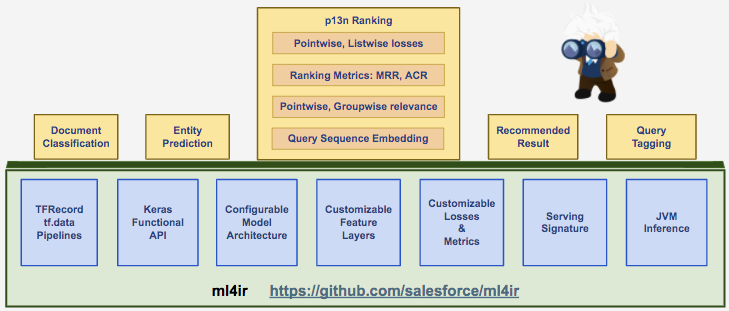

### First, let's load the data and take a look at it

In [1]:
from ml4ir.base.io import file_io
import glob
import logging
import pandas as pd
import os

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Logger is initialized...")


# Load data
CSV_DATA_DIR = '../ml4ir/applications/ranking/tests/data/csv'

df = file_io.read_df_list(glob.glob(os.path.join(CSV_DATA_DIR, "train", "*.csv")), log=logger)

logger.info(df.shape)

df.head().T

DEBUG:root:Logger is initialized...
INFO:root:Reading 1 files from [../ml4ir/applications/ranking/tests/data/csv/train/file_0.csv, ..
INFO:root:(5676, 8)


,0,1,2,3,4
query_key,2,2,5,5,5
query_str,MHS7A7RJB1Y4BJT,MHS7A7RJB1Y4BJT,KNJNWV,KNJNWV,KNJNWV
pos,2,1,6,3,4
feat_0,0.47373,1.06319,1.36811,1.37063,1.3667
feat_1,0,0.205381,0.030636,0.0412615,0.0825349
feat_2,0,0.30103,0,0.30103,0.30103
label,0,1,0,0,0
group,2,2,0,0,0


### Let's define the feature configuration for our data

### ... brace yourselves!

In [2]:
# Set up the feature configurations
from ml4ir.base.features.feature_config import parse_config
from ml4ir.base.features.feature_config import ExampleFeatureConfig
from ml4ir.base.config.keys import TFRecordTypeKey
import json

feature_config_yaml = '''
query_key: 
  name: query_key
  node_name: query_key
  trainable: false
  dtype: int64
  log_at_inference: true
  feature_layer_info:
    type: numeric
    shape: null
  serving_info:
    required: false
    default_value: 0
  tfrecord_type: context
label:
  name: label
  node_name: label
  trainable: false
  dtype: int64
  log_at_inference: true
  feature_layer_info:
    type: numeric
    shape: null
  serving_info:
    required: false
    default_value: 0
  tfrecord_type: sequence
features:
  - name: feat_0
    node_name: feat_0
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: feat_1
    node_name: feat_1
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: feat_2
    node_name: feat_2
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: query_str
    node_name: query_str
    trainable: true
    dtype: string
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
      fn: get_sequence_encoding
      args:
        encoding_type: bilstm
        encoding_size: 128
        embedding_size: 128
        max_length: 20
    preprocessing_info:
      - fn: preprocess_text
        args:
          remove_punctuation: true
          to_lower: true
      - fn: strip_numbers
    serving_info:
      required: true
      default_value: ""
    tfrecord_type: context
  - name: group
    node_name: group
    trainable: true
    dtype: int64
    log_at_inference: false
    is_group_metric_key: true
    feature_layer_info:
      type: numeric
      shape: null
      fn: custom_categorical_embedding
      args:
        vocabulary_size: 16
        embedding_size: 128
    serving_info:
      required: false
      default_value: 0
    tfrecord_type: context
  - name: pos
    node_name: pos
    trainable: false
    dtype: int64
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0
    tfrecord_type: sequence
'''
feature_config: ExampleFeatureConfig = parse_config(TFRecordTypeKey.EXAMPLE, feature_config_yaml, logger=logger)
    
logging.info(json.dumps(feature_config.get_all_features(), indent=4))

INFO:root:Reading feature config from YAML string
INFO:root:Feature config loaded successfully
INFO:root:Trainable Features : 
feat_0
feat_1
feat_2
query_str
group
INFO:root:Label : label
INFO:root:Metadata Features : 
query_key
label
pos
INFO:root:[
    {
        "name": "query_key",
        "node_name": "query_key",
        "trainable": false,
        "dtype": "int64",
        "log_at_inference": true,
        "feature_layer_info": {
            "type": "numeric",
            "shape": null
        },
        "serving_info": {
            "required": false,
            "default_value": 0
        },
        "tfrecord_type": "context"
    },
    {
        "name": "label",
        "node_name": "label",
        "trainable": false,
        "dtype": "int64",
        "log_at_inference": true,
        "feature_layer_info": {
            "type": "numeric",
            "shape": null
        },
        "serving_info": {
            "required": false,
            "default_value": 0
        },
   

## TFRecords - Examples vs SequenceExamples

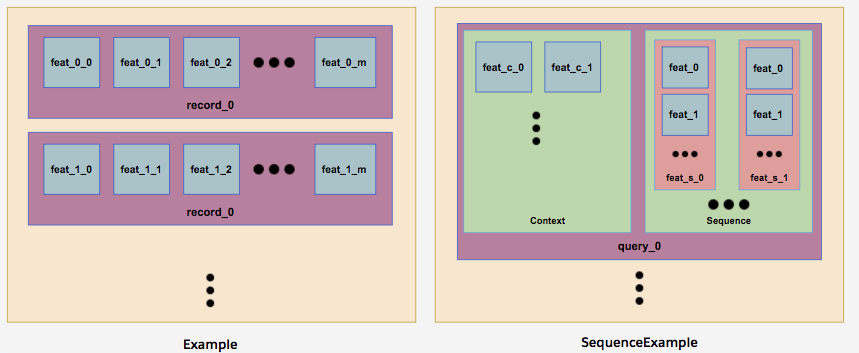

### Time to load the data and save awesome TFRecords

In [3]:
from ml4ir.base.io import file_io
from ml4ir.base.data import tfrecord_writer
import glob
import os

# Load data
df = file_io.read_df_list(glob.glob(os.path.join(CSV_DATA_DIR, "train", "*.csv")))

# Save as TFRecord SequenceExample/Example
TFRECORD_DIR = '../data/pointwise_ranking_demo/'
if not os.path.exists(TFRECORD_DIR):
    os.makedirs('../data/pointwise_ranking_demo/')
tfrecord_writer.write_from_df(df,
                              tfrecord_file=os.path.join(TFRECORD_DIR, 'file_0.tfrecord'),
                              feature_config=feature_config,
                              tfrecord_type=TFRecordTypeKey.EXAMPLE)

# Let's see what it looks like
df.head()

,query_key,query_str,pos,feat_0,feat_1,feat_2,label,group
0,2,MHS7A7RJB1Y4BJT,2,0.473730,0.000000,0.00000,0,2
1,2,MHS7A7RJB1Y4BJT,1,1.063190,0.205381,0.30103,1,2
2,5,KNJNWV,6,1.368108,0.030636,0.00000,0,0
3,5,KNJNWV,3,1.370628,0.041261,0.30103,0,0
4,5,KNJNWV,4,1.366700,0.082535,0.30103,0,0


### Load TFRecords and add custom preprocessing functions

In [4]:
from ml4ir.base.data import tfrecord_reader
from tensorflow import print as tfprint
import tensorflow as tf

@tf.function
def strip_numbers(feature_tensor):
    return tf.strings.regex_replace(feature_tensor, "[0-9]", "")

# Define per instance preprocessing functions
preprocessing_fns = {
    "strip_numbers": strip_numbers
}

# Create a TFRecord dataset
dataset = tfrecord_reader.read(data_dir=TFRECORD_DIR,
                               feature_config=feature_config,
                               tfrecord_type=TFRecordTypeKey.EXAMPLE,
                               preprocessing_keys_to_fns=preprocessing_fns)

tfprint(next(iter(dataset.batch(5))))

{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}
({'feat_0': [[0.473729521]
 [1.06319]
 [1.36810815]
 [1.37062836]
 [1.36669993]],
  'feat_1': [[0]
 [0.205380633]
 [0.0306360275]
 [0.0412614979]
 [0.0825348869]],
  'feat_2': [[0]
 [0.30103]
 [0]
 [0.30103]
 [0.30103]],
  'group': [[2]
 [2]
 [0]
 [0]
 [0]],
  'pos': [[2]
 [1]
 [6]
 [3]
 [4]],
  'query_key': [[2]
 [2]
 [5]
 [5]
 [5]],
  'query_str': [["mhsarjbybjt"]
 ["mhsarjbybjt"]
 ["knjnwv"]
 ["knjnwv"]
 ["knjnwv"]]},
 [[0]
 [1]
 [

### Map, Filter, Filter, Batch the Dataset

In [5]:
# Variety of map, reduce, filter, shuffle operations can be used here
# dataset = dataset.<map, filter, reduce>(tf_preprocess_fn)

# NOTE: This is lazy batching
dataset = dataset.batch(batch_size=128, drop_remainder=True)

### Or... you can do all of that for train, val and test in _one_ step!

In [15]:
from ml4ir.base.data.relevance_dataset import RelevanceDataset
from ml4ir.base.config.keys import DataFormatKey

relevance_dataset = RelevanceDataset(
        data_dir=CSV_DATA_DIR,
        data_format=DataFormatKey.CSV,
        feature_config=feature_config,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        batch_size=128,
        preprocessing_keys_to_fns=preprocessing_fns,
        logger=logger
    )

tfprint(relevance_dataset.train)
tfprint(relevance_dataset.validation)
tfprint(relevance_dataset.test)

INFO:root:Reading 1 files from [../ml4ir/applications/ranking/tests/data/csv/train/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : ../ml4ir/applications/ranking/tests/data/csv/tfrecord/train/file_0.tfrecord
INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['../ml4ir/applications/ranking/tests/data/csv/tfr
INFO:root:Reading 1 files from [../ml4ir/applications/ranking/tests/data/csv/validation/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : ../ml4ir/applications/ranking/tests/data/csv/tfrecord/validation/file_0.tfrecord


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}


INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['../ml4ir/applications/ranking/tests/data/csv/tfr
INFO:root:Reading 1 files from [../ml4ir/applications/ranking/tests/data/csv/test/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : ../ml4ir/applications/ranking/tests/data/csv/tfrecord/test/file_0.tfrecord


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}


INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['../ml4ir/applications/ranking/tests/data/csv/tfr


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}
<BatchDataset shapes: ({query_key: (128, 1), feat_0: (128, 1), feat_1: (128, 1), feat_2: (128, 1), query_str: (128, 1), group: (128, 1), pos: (128, 1)}, (128, 1)), types: ({query_key: tf.int64, feat_0: tf.float32, feat_1: tf.float32, feat_2: tf.float32, query_str: tf.string, group: tf.int64, pos: tf.int64}, tf.int64)>
<BatchDataset shapes: ({query_key: (128, 1), feat_0: (128, 1), feat_1: (128, 1), feat_2: (128, 1), query_str: (128, 1)

## Let's define a model, already!

### Model Framework

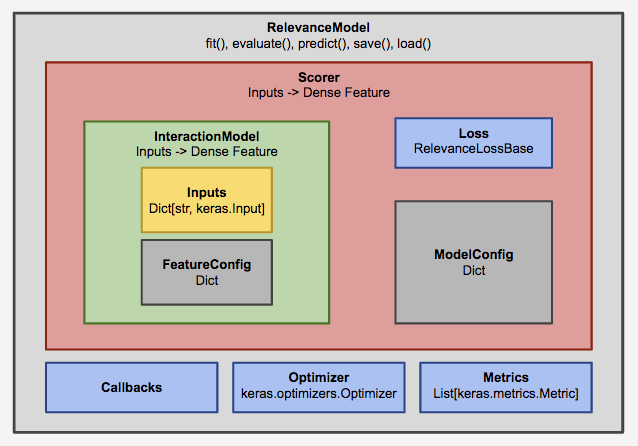

### Step 0: Define the Interaction Model

In [9]:
from ml4ir.base.model.scoring.interaction_model import InteractionModel, UnivariateInteractionModel
from ml4ir.base.config.keys import TFRecordTypeKey

# Define custom feature layer ops
def get_categorical_embedding(input_feature, feature_info):
    """Embedding lookup for categorical features"""
    
    feature_layer_info = feature_info.get("feature_layer_info")
    return layers.Embedding(input_dim=feature_layer_info["args"]["vocabulary_size"],
                     output_dim=feature_layer_info["args"]["embedding_size"],
                     name="categorical_embedding_{}".format(feature_info.get("name")),
                 )(input_feature)

def signed_log(input_tensor, feature_info):
    """Signed log"""
    feature_layer_info = feature_info.get("feature_layer_info")
    return tf.expand_dims(
                tf.math.log(
                    tf.add(input_tensor,
                    tf.cast(tf.constant(feature_layer_info["args"]["shift"]),
                            tf.float32)
                          )
                ),
                axis=-1)

feature_layer_fns = {
    "custom_categorical_embedding": get_categorical_embedding,
    "signed_log": signed_log
}

interaction_model: InteractionModel = UnivariateInteractionModel(
                                            feature_config=feature_config,
                                            feature_layer_keys_to_fns=feature_layer_fns,
                                            tfrecord_type=TFRecordTypeKey.EXAMPLE)

### Step 1: Define the Scorer

In [10]:
from ml4ir.base.model.scoring.scoring_model import ScorerBase, RelevanceScorer
from ml4ir.base.model.losses.loss_base import RelevanceLossBase
from tensorflow.keras import layers
from tensorflow.keras import losses

class MyCustomLoss(RelevanceLossBase):
    def get_loss_fn(self, **kwargs):
        """
        Define a sigmoid cross entropy loss
        Additionally can pass in record positions to handle positional bias

        """
        bce = losses.BinaryCrossentropy(reduction=losses.Reduction.SUM_OVER_BATCH_SIZE)
        mask = kwargs.get("mask")

        def _loss_fn(y_true, y_pred):
            # NOTE: Can use any of the metadata features to qualify your loss here
            return bce(y_true, y_pred)

        return _loss_fn

    def get_final_activation_op(self, output_name):
        return lambda logits, mask: layers.Activation("sigmoid", name=output_name)(logits)

scorer: ScorerBase = RelevanceScorer.from_model_config_file(
    model_config_file='../ml4ir/base/config/default_model_config.yaml',
    interaction_model=interaction_model,
    loss=MyCustomLoss(),
    output_name="relevance_score")
    
logger.info(json.dumps(scorer.model_config, indent=4))

INFO:root:{
    "architecture_key": "dnn",
    "layers": [
        {
            "type": "dense",
            "name": "first_dense",
            "units": 256,
            "activation": "relu"
        },
        {
            "type": "dropout",
            "name": "first_dropout",
            "rate": 0.0
        },
        {
            "type": "dense",
            "name": "second_dense",
            "units": 64,
            "activation": "relu"
        },
        {
            "type": "dropout",
            "name": "second_dropout",
            "rate": 0.0
        },
        {
            "type": "dense",
            "name": "final_dense",
            "units": 1,
            "activation": null
        }
    ]
}


### Step 2: Define Metrics

In [11]:
from tensorflow.keras import metrics as kmetrics

# metrics = ['binary_accuracy', kmetrics.Precision(name='precision')]
metrics = ['binary_accuracy', kmetrics.Precision]

### Step 3: Define Optimizer

In [12]:
from tensorflow.keras.optimizers import Optimizer
from ml4ir.base.model.optimizer import get_optimizer
from ml4ir.base.config.keys import OptimizerKey

optimizer: Optimizer = get_optimizer(
                optimizer_key=OptimizerKey.ADAM,
                learning_rate=0.01,
                learning_rate_decay=0.94,
                learning_rate_decay_steps=1000,
                gradient_clip_value=50,
            )

### Now... let's put it all together

In [13]:
from ml4ir.base.model.relevance_model import RelevanceModel
from ml4ir.base.config.keys import OptimizerKey

relevance_model = RelevanceModel(
        feature_config=feature_config,
        scorer=scorer,
        metrics=metrics,
        optimizer=optimizer,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        output_name="relevance_score",
        logger=logger
    )

INFO:root:Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query_str (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_DecodePaddedRaw (Te [(None, 1, 20)]      0           query_str[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 20)]         0           tf_op_layer_DecodePaddedRaw[0][0]
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 128)      32768       tf_op_layer_Reshape[0][0]        
____________________________________________________________________________________

In [16]:
if not os.path.exists('../models'):
    os.makedirs('../models')
if not os.path.exists('../logs'):
    os.makedirs('../logs')

relevance_model.fit(relevance_dataset, 
                    num_epochs=5, 
                    models_dir='../models',
                    logs_dir='../logs',
                    monitor_metric='val_binary_accuracy',
                    monitor_mode='max')

INFO:root:Training Model
INFO:root:Starting Epoch : 1
INFO:root:{}
INFO:root:[epoch: 1 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.5443852, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 1/5
      1/Unknown - 0s 71ms/step - loss: 0.5444 - binary_accuracy: 0.7500 - precision: 0.0000e+00

     25/Unknown - 2s 69ms/step - loss: 0.5543 - binary_accuracy: 0.7366 - precision: 0.0000e+00

INFO:root:[epoch: 1 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.5578094, 'binary_accuracy': 0.7364784, 'precision': 0.0}


     44/Unknown - 3s 65ms/step - loss: 0.5537 - binary_accuracy: 0.7354 - precision: 0.0000e+00

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None



Epoch 00001: val_binary_accuracy improved from -inf to 0.73899, saving model to ../models/checkpoint.tf


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/checkpoint.tf/assets
INFO:root:End of Epoch 1
INFO:root:{'loss': 0.5536964359608564, 'binary_accuracy': 0.7354403, 'precision': 0.0, 'val_loss': 0.555181623859839, 'val_binary_accuracy': 0.7389915, 'val_precision': 0.0}


44/44 [==============================] - 31s 714ms/step - loss: 0.5537 - binary_accuracy: 0.7354 - precision: 0.0000e+00 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_precision: 0.0000e+00


INFO:root:Starting Epoch : 2
INFO:root:{}
INFO:root:[epoch: 2 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.55346656, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 2/5
25/44 [================>.............] - ETA: 1s - loss: 0.5487 - binary_accuracy: 0.7366 - precision: 0.0000e+00

INFO:root:[epoch: 2 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.5623317, 'binary_accuracy': 0.7364784, 'precision': 0.0}


43/44 [============================>.] - ETA: 0s - loss: 0.5489 - binary_accuracy: 0.7353 - precision: 0.0000e+00

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None
INFO:root:End of Epoch 2
INFO:root:{'loss': 0.5496012202718041, 'binary_accuracy': 0.7354403, 'precision': 0.0, 'val_loss': 0.5532265589995817, 'val_binary_accuracy': 0.7389915, 'val_precision': 0.0}



Epoch 00002: val_binary_accuracy did not improve from 0.73899
44/44 [==============================] - 4s 95ms/step - loss: 0.5496 - binary_accuracy: 0.7354 - precision: 0.0000e+00 - val_loss: 0.5532 - val_binary_accuracy: 0.7390 - val_precision: 0.0000e+00


INFO:root:Starting Epoch : 3
INFO:root:{}
INFO:root:[epoch: 3 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.549949, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 3/5
25/44 [================>.............] - ETA: 1s - loss: 0.5505 - binary_accuracy: 0.7366 - precision: 0.0000e+00

INFO:root:[epoch: 3 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.55756116, 'binary_accuracy': 0.7364784, 'precision': 0.0}


43/44 [============================>.] - ETA: 0s - loss: 0.5492 - binary_accuracy: 0.7353 - precision: 0.0000e+00

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None
INFO:root:End of Epoch 3
INFO:root:{'loss': 0.5498260828581724, 'binary_accuracy': 0.7354403, 'precision': 0.0, 'val_loss': 0.5578028586777773, 'val_binary_accuracy': 0.7389915, 'val_precision': 0.0}



Epoch 00003: val_binary_accuracy did not improve from 0.73899
Restoring model weights from the end of the best epoch.
44/44 [==============================] - 4s 95ms/step - loss: 0.5498 - binary_accuracy: 0.7354 - precision: 0.0000e+00 - val_loss: 0.5578 - val_binary_accuracy: 0.7390 - val_precision: 0.0000e+00


INFO:root:Completed training model
INFO:root:None


Epoch 00003: early stopping


### Let's save the model(...and don't forget about serving signatures)

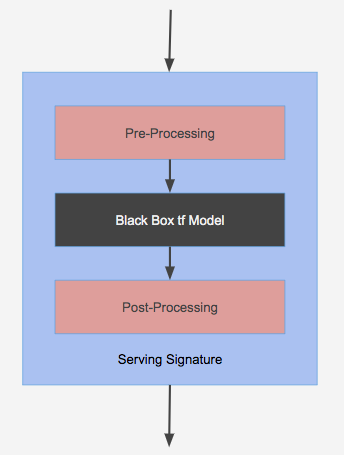

In [17]:
MODEL_DIR = '../models/pointwise_ranking_demo'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    
relevance_model.save(
    models_dir=MODEL_DIR,
    preprocessing_keys_to_fns=preprocessing_fns,
    required_fields_only=True)

INFO:tensorflow:Assets written to: ../models/pointwise_ranking_demo/final/default/assets


{'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}


INFO:tensorflow:Assets written to: ../models/pointwise_ranking_demo/final/tfrecord/assets
INFO:root:Final model saved to : ../models/pointwise_ranking_demo/final


### Reload the model for some predictions

In [37]:
from ml4ir.base.config.keys import TFRecordTypeKey

relevance_model = RelevanceModel(
    feature_config=feature_config,
    tfrecord_type=TFRecordTypeKey.EXAMPLE,
    model_file=os.path.join(MODEL_DIR, 'final/default/'),
    logger=logger,
    output_name="relevance_score"
)

logger.info("Is Keras model? {}".format(isinstance(relevance_model.model, tf.keras.Model)))
logger.info("Is compiled? {}".format(relevance_model.is_compiled))

relevance_model.predict(test_dataset=relevance_dataset.test).sample(25)

INFO:root:Successfully loaded SavedModel from ../models/pointwise_ranking_demo/final/default/
INFO:root:Is Keras model? True
INFO:root:Is compiled? False
INFO:root:Finished predicting scores for 25 batches


,query_key,label,query_str,pos,relevance_score
3,740,0,b'btrnalst',2,0.159647
111,862,0,b'asuckzekq',5,0.330036
71,550,0,b'jxrofi',5,0.150660
112,1289,0,b'vdmw',3,0.194256
24,312,0,b'lbdavmmrydc',2,0.241013
99,716,1,b'qdygiorga',1,0.292963
13,1041,0,b'vivzygb',3,0.131669
96,1305,0,b'wzeixcx',2,0.219538
87,1116,0,b'asdbluvaqd',4,0.173946
47,1225,0,b'deiz',5,0.328670


### Let's see how the TFRecord serving signature works

In [38]:
from tensorflow.keras import models as kmodels
from tensorflow import data

model = kmodels.load_model(
    os.path.join(MODEL_DIR, 'final/tfrecord/'),
    compile=False)
infer_fn = model.signatures["serving_tfrecord"]

dataset = data.TFRecordDataset(
    glob.glob(os.path.join(CSV_DATA_DIR, "tfrecord", "test", "*.tfrecord")))
protos = next(iter(dataset.batch(10)))

logger.info("Example proto: \n{}".format(protos[0]))

logger.info("\n\n\nPredictions:")
logger.info(infer_fn(protos=protos))

INFO:root:Example proto: 
b'\n\x9a\x01\n\x12\n\x06feat_0\x12\x08\x12\x06\n\x044\xb4\x19?\n\x12\n\x06feat_1\x12\x08\x12\x06\n\x04]\x04G>\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n\x12\n\x06feat_2\x12\x08\x12\x06\n\x04\x9b \x9a>\n\x0e\n\x05group\x12\x05\x1a\x03\n\x01\x01\n\x1a\n\tquery_str\x12\r\n\x0b\n\tLVA3934GV\n\x12\n\tquery_key\x12\x05\x1a\x03\n\x01\x01\n\x0c\n\x03pos\x12\x05\x1a\x03\n\x01\x02'
INFO:root:


Predictions:
INFO:root:{'relevance_score': <tf.Tensor: id=467301, shape=(10, 1), dtype=float32, numpy=
array([[0.28492698],
       [0.35929203],
       [0.15038341],
       [0.2560033 ],
       [0.26309642],
       [0.14505771],
       [0.2560033 ],
       [0.2990865 ],
       [0.2936227 ],
       [0.2741116 ]], dtype=float32)>}


### Why you should onboard your ML application to ml4ir today!

* Consistent code structure and modularization across projects
* Scalable TFRecord data pipeline
    * Every ML application shouldn’t have to reinvent the wheel especially when there is barely any documentation on this.
    * Consistent file I/O overall
* Consistent library versions across projects
    * Easily update versions and validate inference time impact, etc
* Common Flowsnake enablement
    * We can define _git.soma/MLConfigs_ to track and automatically build docker images through strata from ml4ir.
* Unified python ↔ JVM interoperability
    * Define integration tests
    * Allows us to build generic protobuf creation at runtime
* Common training abstraction
    * Callbacks : checkpointing, early stopping, tensorboard, etc
    * Consistent way to save models
        * allows us to have generic deployment code
* Shared metrics, losses, layers, etc.
* Shared feature processing and feature layers across ML models
    * long term: shared NLP toolkit, probability toolkit
    * short term: categorical, text embeddings
* Build models that can be trained with tight coupling:
    * transfer learning
    * shared embedding layers
    * multi task models



> ### This is just the `end of the beginning` and we would love to take new passengers on this journey!

![thanks](https://media.giphy.com/media/lD76yTC5zxZPG/giphy.gif)

                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .


                                                            .

<center>Psst... You can file github issues -> <a href="https://github.com/salesforce/ml4ir/issues">HERE!</a></center>

![shhh](https://media.giphy.com/media/xZvXaVgssJnu8/giphy.gif)